<a href="https://colab.research.google.com/github/Francescolaz/AlgorithmsMassiveDatasets-project/blob/main/AMD_Project_GITHUB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMD - Project 2020/21

## Francesco Lazzara 942830

“I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study.“

# Dowload the dataset from Kaggle API 

URL-link to the dataset: <https://www.kaggle.com/ashirwadsangwan/imdb-dataset?select=title.basics.tsv.gz​>

In [1]:
 # Install the "kaggle" library to establish the connection with the Kaggle API

!pip install -q kaggle

# Upload the "kaggle.json" file with the credentials for the Kaggle API

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"francescolaz","key":"e4e7aedec77147b9f0dea02fb3216c54"}'}

In [2]:
# Copy the Kaggle API token "kaggle.json", downloaded from the Github folder of the project, and paste it in the .kaggle folder (Google Drive)

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
# Mount Google Drive to use the storage space for downloading the dataset

from google.colab import drive


# Follow the URL-link to get the authorization code to connect Google Drive with Colab and use it as storage 
# (it might be asked the first time the code is executed with a different Google Drive storage)

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
 # Change the permissions of the file
 
 !chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Paste the Kaggle API command to download the IMDb dataset

!kaggle datasets download -d ashirwadsangwan/imdb-dataset

 99% 1.43G/1.44G [00:14<00:00, 99.6MB/s]
100% 1.44G/1.44G [00:14<00:00, 107MB/s] 


In [6]:
# Check the files contained in the workind directory

!ls

drive  imdb-dataset.zip  kaggle.json  sample_data


In [7]:
# Unzip the "imdb-dataset" and delete the zip file

!unzip \*.zip  && rm *.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


## Install Spark

We would try to extract only the actor/actress observations from the "title.principals.ts" table, along with the "*tconst* and "*nconst*" columns to link the actors to their name ("nconst") and movies ("tconst").

In [8]:
# Install Java
# Install Spark (change the version number according to: https://downloads.apache.org/spark/)
# Unzip the Spark file to the current folder
# Install Findspark using pip

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar xf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [9]:
# Set the Spark folder to the system path environment

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark

# Locate Spark in the system

findspark.init()
findspark.find()

'/content/spark-3.0.3-bin-hadoop2.7'

In [10]:
# Start a Spark session

from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .config("spark.driver.memory", "15g")\
        .getOrCreate()

In [11]:
print(spark, type(spark))

<pyspark.sql.session.SparkSession object at 0x7f07adde7390> <class 'pyspark.sql.session.SparkSession'>


In [12]:
# The SparkContext represents the connection to a Spark cluster and can be used to create RDD and broadcast variables

from pyspark import SparkContext

sc = spark.sparkContext

## Data Pre-processing

---



In [13]:
# Read the "tsv" file with the Movie titles

titles = spark.read.csv("/content/title.basics.tsv/title.basics.tsv", 
               sep=r'\t', header=True).select("tconst", "titleType", "PrimaryTitle", "originalTitle", "genres")

print(titles.count())

6321302


In [14]:
# Inspect if there are nan values - TITLES

from pyspark.sql.functions import isnan, when, count, col

titles.select([count(when(isnan(c), c)).alias(c) for c in titles.columns]).show()

+------+---------+------------+-------------+------+
|tconst|titleType|PrimaryTitle|originalTitle|genres|
+------+---------+------------+-------------+------+
|     0|        0|           7|            7|     0|
+------+---------+------------+-------------+------+



In [15]:
# Remove the null values from the dataset

titles = titles.filter("PrimaryTitle != 'Nan' and originalTitle != 'Nan'")

print(titles.count())

6321295


In [16]:
titles.head(10)

[Row(tconst='tt0000001', titleType='short', PrimaryTitle='Carmencita', originalTitle='Carmencita', genres='Documentary,Short'),
 Row(tconst='tt0000002', titleType='short', PrimaryTitle='Le clown et ses chiens', originalTitle='Le clown et ses chiens', genres='Animation,Short'),
 Row(tconst='tt0000003', titleType='short', PrimaryTitle='Pauvre Pierrot', originalTitle='Pauvre Pierrot', genres='Animation,Comedy,Romance'),
 Row(tconst='tt0000004', titleType='short', PrimaryTitle='Un bon bock', originalTitle='Un bon bock', genres='Animation,Short'),
 Row(tconst='tt0000005', titleType='short', PrimaryTitle='Blacksmith Scene', originalTitle='Blacksmith Scene', genres='Comedy,Short'),
 Row(tconst='tt0000006', titleType='short', PrimaryTitle='Chinese Opium Den', originalTitle='Chinese Opium Den', genres='Short'),
 Row(tconst='tt0000007', titleType='short', PrimaryTitle='Corbett and Courtney Before the Kinetograph', originalTitle='Corbett and Courtney Before the Kinetograph', genres='Short,Sport')

In [17]:
# Read the "tsv" file with the Individual job's for each movie

job = spark.read.csv("/content/title.principals.tsv/title.principals.tsv", 
                    sep=r'\t', header=True).select("tconst", "ordering", "nconst", "category")

print(job.count())

36468817


In [18]:
# Inspect if there are null values - JOB

job.select([count(when(isnan(c), c)).alias(c) for c in job.columns]).show()

+------+--------+------+--------+
|tconst|ordering|nconst|category|
+------+--------+------+--------+
|     0|       0|     0|       0|
+------+--------+------+--------+



In [19]:
job.head(10)

[Row(tconst='tt0000001', ordering='1', nconst='nm1588970', category='self'),
 Row(tconst='tt0000001', ordering='2', nconst='nm0005690', category='director'),
 Row(tconst='tt0000001', ordering='3', nconst='nm0374658', category='cinematographer'),
 Row(tconst='tt0000002', ordering='1', nconst='nm0721526', category='director'),
 Row(tconst='tt0000002', ordering='2', nconst='nm1335271', category='composer'),
 Row(tconst='tt0000003', ordering='1', nconst='nm0721526', category='director'),
 Row(tconst='tt0000003', ordering='2', nconst='nm5442194', category='producer'),
 Row(tconst='tt0000003', ordering='3', nconst='nm1335271', category='composer'),
 Row(tconst='tt0000003', ordering='4', nconst='nm5442200', category='editor'),
 Row(tconst='tt0000004', ordering='1', nconst='nm0721526', category='director')]

In [20]:
# Read the "tsv" file with the Actor name's for each job

actors = spark.read.csv("/content/name.basics.tsv/name.basics.tsv", 
               sep=r'\t', header=True).select("nconst", "primaryName", "birthYear", "deathYear", "knownForTitles")

print(actors.count())

9706922


In [21]:
# Inspect if there are null values - ACTORS

actors.select([count(when(isnan(c), c)).alias(c) for c in actors.columns]).show()

+------+-----------+---------+---------+--------------+
|nconst|primaryName|birthYear|deathYear|knownForTitles|
+------+-----------+---------+---------+--------------+
|     0|          7|        0|        0|             0|
+------+-----------+---------+---------+--------------+



In [22]:
# Remove the null values from the dataset

actors = actors.filter("primaryName != 'Nan'")

print(actors.count())

9706915


In [23]:
actors.head(10)

[Row(nconst='nm0000001', primaryName='Fred Astaire', birthYear='1899', deathYear='1987', knownForTitles='tt0050419,tt0053137,tt0072308,tt0043044'),
 Row(nconst='nm0000002', primaryName='Lauren Bacall', birthYear='1924', deathYear='2014', knownForTitles='tt0071877,tt0117057,tt0038355,tt0037382'),
 Row(nconst='nm0000003', primaryName='Brigitte Bardot', birthYear='1934', deathYear='\\N', knownForTitles='tt0054452,tt0049189,tt0059956,tt0057345'),
 Row(nconst='nm0000004', primaryName='John Belushi', birthYear='1949', deathYear='1982', knownForTitles='tt0077975,tt0072562,tt0080455,tt0078723'),
 Row(nconst='nm0000005', primaryName='Ingmar Bergman', birthYear='1918', deathYear='2007', knownForTitles='tt0069467,tt0050976,tt0083922,tt0050986'),
 Row(nconst='nm0000006', primaryName='Ingrid Bergman', birthYear='1915', deathYear='1982', knownForTitles='tt0038109,tt0036855,tt0077711,tt0038787'),
 Row(nconst='nm0000007', primaryName='Humphrey Bogart', birthYear='1899', deathYear='1957', knownForTitle

In [24]:
# Extract the list of movies from the titles DataFrame

print('Number of movies in the Dataset: {}\n'.format(titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle") \
            .rdd.map(lambda row : row[:3]).count()))

(titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle") \
            .rdd.map(lambda row : row[:3]).take(50))

Number of movies in the Dataset: 536032



[('tt0000009', 'movie', 'Miss Jerry'),
 ('tt0000147', 'movie', 'The Corbett-Fitzsimmons Fight'),
 ('tt0000335', 'movie', 'Soldiers of the Cross'),
 ('tt0000502', 'movie', 'Bohemios'),
 ('tt0000574', 'movie', 'The Story of the Kelly Gang'),
 ('tt0000615', 'movie', 'Robbery Under Arms'),
 ('tt0000630', 'movie', 'Hamlet'),
 ('tt0000675', 'movie', 'Don Quijote'),
 ('tt0000676', 'movie', 'Don Álvaro o la fuerza del sino'),
 ('tt0000679', 'movie', 'The Fairylogue and Radio-Plays'),
 ('tt0000739', 'movie', 'El pastorcito de Torrente'),
 ('tt0000793', 'movie', 'Andreas Hofer'),
 ('tt0000812', 'movie', 'El blocao Velarde'),
 ('tt0000814', 'movie', 'La bocana de Mar Chica'),
 ('tt0000838', 'movie', 'A Cultura do Cacau'),
 ('tt0000842', 'movie', 'De Garraf a Barcelona'),
 ('tt0000846', 'movie', 'Un día en Xochimilco'),
 ('tt0000850', 'movie', 'Los dos hermanos'),
 ('tt0000859', 'movie', 'Fabricación del corcho en Sant Feliu de Guixols'),
 ('tt0000862', 'movie', 'Faldgruben'),
 ('tt0000867', 'movi

In [25]:
# Create a DataFrame containing the actors and the movies they played in

df_actors = job.filter((job.category == "actor") | (job.category == "actress")).select("tconst", "nconst", "category")


# Get the name of the actors for each movie played (with repetitions)

df_actors = df_actors.join(actors, df_actors.nconst == actors.nconst) \
                     .select(df_actors.tconst, df_actors.nconst, "primaryName", "category")


# Retrieve from the "titles" table only the movies ("tytleType"), by not including for example tvseries (Episode #1.x)

only_movies = titles.filter(titles.titleType == "movie").select("tconst", "titleType", "primaryTitle")


# Connect each actor with the movies he/she played in

df_actors = df_actors.join(only_movies, df_actors.tconst == only_movies.tconst) \
                     .select(df_actors.tconst, df_actors.nconst, "primaryName", "category", "titleType", "primaryTitle")

print(df_actors.count())

1692933


In [26]:
df_actors.show(50)

+---------+---------+--------------------+--------+---------+--------------------+
|   tconst|   nconst|         primaryName|category|titleType|        primaryTitle|
+---------+---------+--------------------+--------+---------+--------------------+
|tt0002591|nm0509573|       Harry Liedtke|   actor|    movie|             Zu spät|
|tt0002591|nm0029806|Martha Angerstein...| actress|    movie|             Zu spät|
|tt0003689|nm0585503| George W. Middleton|   actor|    movie|          Born Again|
|tt0003689|nm0694718|      Beulah Poynter| actress|    movie|          Born Again|
|tt0003689|nm0101071|         John Bowers|   actor|    movie|          Born Again|
|tt0003689|nm0910564|      Mrs. E. Walton| actress|    movie|          Born Again|
|tt0003689|nm0527801|        Octave Luzon|   actor|    movie|          Born Again|
|tt0003689|nm0399988|       Wilbur Hudson|   actor|    movie|          Born Again|
|tt0003689|nm0728289|   William S. Rising|   actor|    movie|          Born Again|
|tt0

In [27]:
# Look a the first ten movies with the most number of actors

from pyspark.sql.functions import desc

df_actors.groupBy(["tconst", "PrimaryTitle"]).count().sort(desc("count")).head(10)

[Row(tconst='tt0205101', PrimaryTitle='The Grue Crew', count=10),
 Row(tconst='tt0816517', PrimaryTitle='The Gypsy Ball', count=10),
 Row(tconst='tt3166672', PrimaryTitle='Emmanuelle Through Time: Rod Steele 0014 & Naked Agent 0069', count=10),
 Row(tconst='tt0259293', PrimaryTitle='En Thangai Kalyani', count=10),
 Row(tconst='tt4921338', PrimaryTitle='The Break-In', count=10),
 Row(tconst='tt5870174', PrimaryTitle='Batman Beyond: Rising Knight', count=10),
 Row(tconst='tt9347518', PrimaryTitle='Stick To The Status Quo', count=10),
 Row(tconst='tt3611440', PrimaryTitle='Home in Time for War', count=10),
 Row(tconst='tt0404419', PrimaryTitle='El sexenio de la muerte', count=10),
 Row(tconst='tt2289062', PrimaryTitle="Another 'Brief' Case", count=10)]

In [28]:
# Erroneously grouping of the movies by "PrimaryTitle"

df_actors.groupBy("PrimaryTitle").count().sort(desc("count")).head(10)

[Row(PrimaryTitle='Hamlet', count=145),
 Row(PrimaryTitle='Macbeth', count=140),
 Row(PrimaryTitle='Honeymoon', count=139),
 Row(PrimaryTitle='Broken', count=131),
 Row(PrimaryTitle='Alone', count=128),
 Row(PrimaryTitle='Love', count=127),
 Row(PrimaryTitle='Desire', count=125),
 Row(PrimaryTitle='Mother', count=123),
 Row(PrimaryTitle='Homecoming', count=117),
 Row(PrimaryTitle='Revenge', count=115)]

---

## Project 2: Market-basket analysis

The task is to implement a system finding frequent itemsets (aka market-basket analysis), analyzing one of the two datasets described below.
IMDB
The «​IMDB​» dataset is published on Kaggle, under I​MDB non-commercial licensing​. The analysis must be done considering movies as baskets and actors as items.

In general, we only need small frequent itemsets with *k* that nevers grows beyond 2 or 3 (subset size).

In [29]:
# Create the set of baskets (movies) with items (actors) as a list of items for each each basket [[item1, item2, ...], ..., []]

from pyspark.sql import functions as F

baskets_list = (df_actors.groupby("tconst").agg(F.collect_list("primaryName")).rdd.map(lambda row: row[1]).collect())

print(len(baskets_list))

393653


In [30]:
baskets_list[:10]

[['Harry Liedtke', 'Martha Angerstein-Licho'],
 ['George W. Middleton',
  'Beulah Poynter',
  'John Bowers',
  'Mrs. E. Walton',
  'Octave Luzon',
  'Wilbur Hudson',
  'William S. Rising'],
 ['Harry Schumm',
  'Wilbur Higby',
  'Francis Ford',
  'Edgar Keller',
  'Burton Law',
  'Eddie Boland',
  'Jean Hathaway',
  'Grace Cunard',
  'Ernest Shields'],
 ['Florence La Badie',
  'Sidney Bracey',
  'Frank Farrington',
  'Marguerite Snow',
  'James Cruze'],
 ['DeWolf Hopper Sr.',
  'Julia Faye',
  'Fay Tincher',
  'Max Davidson',
  'George Walsh',
  'Rhea Mitchell'],
 ['Ellis F. Glickman',
  'Lucy Payton',
  'W.H. Harriman',
  'Arthur Bauer',
  'Minnie Berlin',
  'Nolan Gane'],
 ['Wingold Lawrence', 'Flora Morris'],
 ['Constance Bennett',
  'Joan Bennett',
  'Blanche Bennett',
  'George Periolat',
  'Barbara Bennett',
  'Richard Bennett',
  'Rhoda Lewis',
  'Adrienne Morrison'],
 ['Henry Hallam',
  'Francesca Cappelano',
  'Hal Forde',
  'Marguerite Courtot',
  'T. Justin Dow',
  'Helen Lin

## A-Priori algorithm

It is designed to reduce the number of pairs that must be counted, at the expense of performing two passes over the data.

In [31]:
# Get the unique name of actors in the list of baskets and hash each of them to a unique integer (from 0 to n)

items_to_hash = dict(enumerate(sc.parallelize(baskets_list).flatMap(lambda bask: bask).distinct().collect(), 0))

print(len(items_to_hash))

560653


In [32]:
list(items_to_hash.items())[:10]

[(0, 'Harry Liedtke'),
 (1, 'Martha Angerstein-Licho'),
 (2, 'George W. Middleton'),
 (3, 'Beulah Poynter'),
 (4, 'John Bowers'),
 (5, 'Mrs. E. Walton'),
 (6, 'Octave Luzon'),
 (7, 'Wilbur Hudson'),
 (8, 'William S. Rising'),
 (9, 'Harry Schumm')]

In [33]:
# Alternative dictionary with items as keys and hash as values (used to remap integers to actors name)

key_actors = dict(zip(items_to_hash.values(), items_to_hash.keys()))

print(len(key_actors))

560653


In [34]:
list(key_actors.items())[:10]

[('Harry Liedtke', 0),
 ('Martha Angerstein-Licho', 1),
 ('George W. Middleton', 2),
 ('Beulah Poynter', 3),
 ('John Bowers', 4),
 ('Mrs. E. Walton', 5),
 ('Octave Luzon', 6),
 ('Wilbur Hudson', 7),
 ('William S. Rising', 8),
 ('Harry Schumm', 9)]

In [35]:
# Hash table

spark.createDataFrame(items_to_hash.items(), schema = ["Hash", "Item"]).show(50)

+----+--------------------+
|Hash|                Item|
+----+--------------------+
|   0|       Harry Liedtke|
|   1|Martha Angerstein...|
|   2| George W. Middleton|
|   3|      Beulah Poynter|
|   4|         John Bowers|
|   5|      Mrs. E. Walton|
|   6|        Octave Luzon|
|   7|       Wilbur Hudson|
|   8|   William S. Rising|
|   9|        Harry Schumm|
|  10|        Wilbur Higby|
|  11|        Francis Ford|
|  12|        Edgar Keller|
|  13|          Burton Law|
|  14|        Eddie Boland|
|  15|       Jean Hathaway|
|  16|        Grace Cunard|
|  17|      Ernest Shields|
|  18|   Florence La Badie|
|  19|       Sidney Bracey|
|  20|    Frank Farrington|
|  21|     Marguerite Snow|
|  22|         James Cruze|
|  23|   DeWolf Hopper Sr.|
|  24|          Julia Faye|
|  25|         Fay Tincher|
|  26|        Max Davidson|
|  27|        George Walsh|
|  28|       Rhea Mitchell|
|  29|   Ellis F. Glickman|
|  30|         Lucy Payton|
|  31|       W.H. Harriman|
|  32|        Arthur

In [36]:
# Format the list of baskets with actors to baskets with the corresponding hash values

baskets_hash = (sc.parallelize(baskets_list)
                  .map(lambda basket: [key_actors[item] for item in basket])
                  .collect())

baskets_hash[:50]

[[0, 1],
 [2, 3, 4, 5, 6, 7, 8],
 [9, 10, 11, 12, 13, 14, 15, 16, 17],
 [18, 19, 20, 21, 22],
 [23, 24, 25, 26, 27, 28],
 [29, 30, 31, 32, 33, 34],
 [35, 36],
 [37, 38, 39, 40, 41, 42, 43, 44],
 [45, 46, 47, 48, 49, 50],
 [51, 52, 27, 53],
 [54, 55, 56, 57],
 [58, 59, 60, 61, 62, 63],
 [64, 65, 66, 67],
 [68, 69, 70, 71, 72],
 [73, 74, 75, 36, 76, 77],
 [78, 79, 80, 81],
 [82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95],
 [96, 97, 98],
 [99, 100, 101, 102],
 [103, 104, 105, 106, 107, 108],
 [109, 110, 111, 112, 113, 114],
 [115, 116, 103, 117, 118, 119],
 [120, 121, 122, 123],
 [124, 125, 126, 127, 128, 129],
 [130, 131, 132, 133, 134, 135, 136, 137],
 [138, 139, 140, 141],
 [142, 143, 144, 145, 146, 147],
 [148, 149],
 [150, 151, 152, 153, 154, 155],
 [156, 157, 158, 159, 160, 161, 162],
 [163, 146, 164, 165],
 [166, 167, 168, 169, 170],
 [171, 172, 173, 174, 175],
 [176, 177, 178, 179, 180, 181],
 [182, 183, 184, 185, 186, 187],
 [188, 189, 190, 191, 192],
 [193, 194, 195,

In [37]:
# Count the occurrence of each item over all the baskets - SINGLETON (itemsets of size 1)

array_counts = sorted((sc.parallelize(baskets_hash)
                          .flatMap(lambda basket: [(item, 1) for item in basket])
                          .reduceByKey(lambda a, b: a + b)
                          .collect()), key=lambda a: a[0], reverse=False)

print(len(array_counts))

560653


In [38]:
array_counts[:50]

[(0, 132),
 (1, 13),
 (2, 5),
 (3, 6),
 (4, 89),
 (5, 2),
 (6, 1),
 (7, 3),
 (8, 2),
 (9, 3),
 (10, 35),
 (11, 56),
 (12, 4),
 (13, 7),
 (14, 6),
 (15, 12),
 (16, 24),
 (17, 14),
 (18, 19),
 (19, 33),
 (20, 8),
 (21, 29),
 (22, 25),
 (23, 6),
 (24, 20),
 (25, 7),
 (26, 19),
 (27, 62),
 (28, 30),
 (29, 1),
 (30, 7),
 (31, 1),
 (32, 19),
 (33, 1),
 (34, 2),
 (35, 5),
 (36, 6),
 (37, 51),
 (38, 68),
 (39, 1),
 (40, 50),
 (41, 3),
 (42, 22),
 (43, 1),
 (44, 6),
 (45, 24),
 (46, 2),
 (47, 4),
 (48, 27),
 (49, 1)]

In [39]:
# Format the frequent triples from items to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0]], basket[1])))
                          .collect()), key=lambda a: a[1], reverse = True)

print(len(actors_counts))

560653


In [40]:
actors_counts[:100]

[('Brahmanandam', 798),
 ('Adoor Bhasi', 585),
 ('Matsunosuke Onoe', 565),
 ('Eddie Garcia', 507),
 ('Prem Nazir', 438),
 ('Sung-il Shin', 411),
 ('Paquito Diaz', 391),
 ('Masayoshi Nogami', 387),
 ('Mammootty', 381),
 ('Aachi Manorama', 355),
 ('Bahadur', 348),
 ('Mohanlal', 344),
 ('Mithun Chakraborty', 330),
 ('Shivaji Ganesan', 323),
 ('Sultan Rahi', 315),
 ('Nagesh', 313),
 ('Shakti Kapoor', 310),
 ('Tom Byron', 303),
 ('Jayabharati', 303),
 ('Madhu', 303),
 ('Pandharibai', 303),
 ('Jagathi Sreekumar', 299),
 ('Ron Jeremy', 295),
 ('Cüneyt Arkin', 294),
 ('George Estregan', 292),
 ('Taraka Rama Rao Nandamuri', 287),
 ('Helen', 285),
 ('Ashok Kumar', 281),
 ('Anjali Devi', 276),
 ('Seiji Nakamitsu', 273),
 ('Dharmendra', 272),
 ('Max Alvarado', 265),
 ('Meena', 264),
 ('Anup Kumar', 264),
 ('Balkrishna', 261),
 ('Thikkurisi Sukumaran Nair', 260),
 ('Gummadi', 260),
 ('Pran', 256),
 ('Akkineni Nageshwara Rao', 255),
 ('Aruna Irani', 251),
 ('Sukumari', 250),
 ('Ali', 250),
 ('Eric R

In [41]:
# Inspect the mean value of movies played by actors/actresses to set the support treshold

print('Mean value of movies played by actors/actresses: {}'.format(round((sc.parallelize(array_counts).map(lambda tup: tup[1]).mean()), 2)))

Mean value of movies played by actors/actresses: 3.02


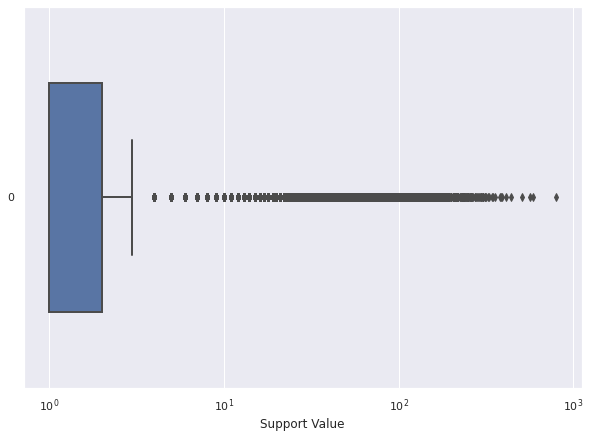

In [42]:
# Boxplot of the distribution of counts in Log scale

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.set(style="darkgrid")
g = sns.boxplot(data=[val[1] for val in array_counts], linewidth=2, width=.6, orient="h")
g.set_xscale("log")
g.set(xlabel="Support Value")
plt.show()

In [43]:
# Set the support threshold to the 95% percentile that corresponds to 10 movies played

import numpy as np

np.percentile([val[1] for val in array_counts], 95)

10.0

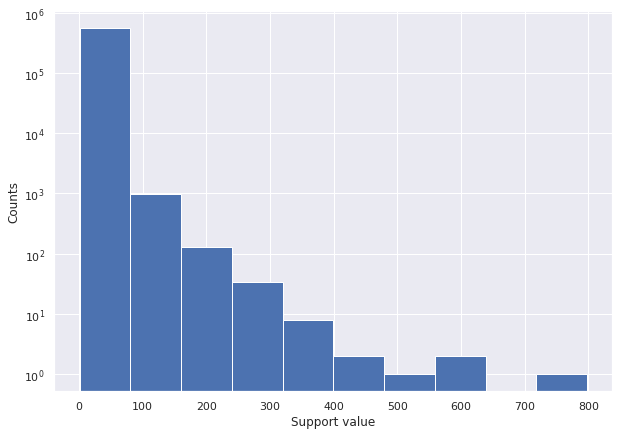

In [44]:
# Histogram of the distribution of counts in Log scale

plt.figure(figsize=(10, 7))
plt.hist(x=[val[1] for val in array_counts], log=True)
plt.xlabel("Support value")
plt.ylabel("Counts")
plt.show()

In [45]:
# Hashed value of the first-ranked actor for number of movies

print(key_actors['Brahmanandam'], key_actors['Adoor Bhasi'], key_actors['Matsunosuke Onoe'])

4924 2024 4354


In [46]:
# Average length of each basket

print("The average number of actors in each basket is: {}".format(round((sc.parallelize(baskets_hash))
                                                                           .map(lambda basket: len(basket))
                                                                           .mean(), 2)))

The average number of actors in each basket is: 4.3


In [47]:
# Inspect the average number of actors in the movies played by "Brahmanandam"

Brahmanandam_avgmovies = (sc.parallelize(baskets_hash)
                            .map(lambda basket: len(basket) if 4924 in basket else 0)
                            .collect())

print("The average number of actors in the movies played by 'Brahmanandam' is : {}".format(round(np.mean([val for val in Brahmanandam_avgmovies if val != 0]), 2)))

The average number of actors in the movies played by 'Brahmanandam' is : 4.25


In [48]:
# Frequent-items table - SINGLETON
# entry i-th is -1 if item "i" is not frequent, while the i-th entry is its hashed value if the item "i" is frequent

freqitem_table = (sc.parallelize(array_counts)
                    .map(lambda basket: -1 if basket[1] <= 10 else basket[0])
                    .collect())

freqitem_table[:50]

[0,
 1,
 -1,
 -1,
 4,
 -1,
 -1,
 -1,
 -1,
 -1,
 10,
 11,
 -1,
 -1,
 -1,
 15,
 16,
 17,
 18,
 19,
 -1,
 21,
 22,
 -1,
 24,
 -1,
 26,
 27,
 28,
 -1,
 -1,
 -1,
 32,
 -1,
 -1,
 -1,
 -1,
 37,
 38,
 -1,
 40,
 -1,
 42,
 -1,
 -1,
 45,
 -1,
 -1,
 48,
 -1]

In [49]:
# Inspect the frequent items in each basket

freqbaskets_hash = (sc.parallelize(baskets_hash)
                      .map(lambda basket: [freqitem_table[item] for item in basket if freqitem_table[item] != -1])
                      .collect())


# Remove non frequent items in the baskets

freqbaskets_hash = (sc.parallelize(freqbaskets_hash)
                      .map(lambda basket: [item for item in basket if item != -1])
                      .collect())


# Remove the empty baskets and the ones with length lower than 2

freqbaskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 2, freqbaskets_hash))
print(len(freqbaskets_hash))

198755


In [50]:
freqbaskets_hash[:50]

[[0, 1],
 [10, 11, 15, 16, 17],
 [18, 19, 21, 22],
 [24, 26, 27, 28],
 [37, 38, 40, 42],
 [45, 48, 50],
 [52, 27, 53],
 [55, 56, 57],
 [58, 59, 61, 63],
 [66, 67],
 [68, 69, 70, 71, 72],
 [73, 75, 77],
 [78, 79, 81],
 [83, 84, 86, 87, 88],
 [91, 93, 95],
 [103, 105, 107, 108],
 [111, 112, 113],
 [115, 116, 103, 118, 119],
 [120, 121, 122, 123],
 [124, 125, 126, 127, 128, 129],
 [133, 136, 137],
 [140, 141],
 [143, 144, 146, 147],
 [148, 149],
 [151, 152, 153, 154, 155],
 [156, 157, 158, 159, 160, 162],
 [163, 146, 164, 165],
 [167, 168, 169, 170],
 [171, 172, 175],
 [183, 187],
 [189, 190],
 [193, 195, 196, 198],
 [199, 201, 202, 206],
 [208, 209, 210, 211],
 [214, 215, 216, 218],
 [224, 225, 226, 229, 230, 231],
 [10, 241, 242, 244, 246],
 [247, 248, 249, 66, 250],
 [252, 253, 254, 255],
 [257, 258, 259, 260],
 [261, 262, 263, 264, 265],
 [266, 267, 268, 269, 270],
 [273, 274, 275, 276, 277],
 [278, 279, 280, 281],
 [282, 147, 283, 284],
 [278, 254, 286],
 [287, 288, 290, 291, 292],
 

In [51]:
# Count the occurrence of each item over all the baskets - DOUBLETON (itemsets of size 2)

from itertools import combinations

array_counts = (sc.parallelize(freqbaskets_hash)
                  .map(lambda basket: combinations(basket, 2))
                  .flatMap(lambda pairs: [(pair, 1) for pair in pairs])
                  .reduceByKey(lambda a, b: a + b)
                  .collect())

print(len(array_counts))

675815


In [52]:
array_counts[:50]

[((0, 1), 2),
 ((10, 11), 1),
 ((10, 15), 2),
 ((10, 16), 1),
 ((10, 17), 1),
 ((11, 15), 2),
 ((11, 16), 8),
 ((11, 17), 2),
 ((15, 16), 2),
 ((15, 17), 1),
 ((16, 17), 2),
 ((18, 19), 2),
 ((18, 21), 2),
 ((18, 22), 4),
 ((19, 21), 2),
 ((19, 22), 2),
 ((21, 22), 6),
 ((24, 26), 1),
 ((24, 27), 1),
 ((24, 28), 1),
 ((26, 27), 1),
 ((26, 28), 1),
 ((27, 28), 1),
 ((37, 38), 1),
 ((37, 40), 1),
 ((37, 42), 2),
 ((38, 40), 1),
 ((38, 42), 1),
 ((40, 42), 5),
 ((45, 48), 2),
 ((45, 50), 4),
 ((48, 50), 2),
 ((52, 27), 7),
 ((52, 53), 2),
 ((27, 53), 4),
 ((55, 56), 2),
 ((55, 57), 1),
 ((56, 57), 4),
 ((58, 59), 4),
 ((58, 61), 3),
 ((58, 63), 2),
 ((59, 61), 7),
 ((59, 63), 6),
 ((61, 63), 5),
 ((66, 67), 3),
 ((68, 69), 1),
 ((68, 70), 1),
 ((68, 71), 6),
 ((68, 72), 2),
 ((69, 70), 1)]

In [53]:
# Format frequent pairs to actor names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

actors_counts[:100]

[(('Adoor Bhasi', 'Prem Nazir'), 237),
 (('Bahadur', 'Adoor Bhasi'), 169),
 (('Jayabharati', 'Adoor Bhasi'), 162),
 (('Kijaku Ôtani', 'Matsunosuke Onoe'), 147),
 (('Kitsuraku Arashi', 'Matsunosuke Onoe'), 126),
 (('Adoor Bhasi', 'Thikkurisi Sukumaran Nair'), 122),
 (('Kitsuraku Arashi', 'Kijaku Ôtani'), 113),
 (('Suminojo Ichikawa', 'Matsunosuke Onoe'), 113),
 (('Jayabharati', 'Bahadur'), 109),
 (('Panchito', 'Dolphy'), 103),
 (('Prem Nazir', 'Thikkurisi Sukumaran Nair'), 101),
 (('Kijaku Ôtani', 'Suminojo Ichikawa'), 101),
 (('Kitsuraku Arashi', 'Suminojo Ichikawa'), 97),
 (("Sen'nosuke Nakamura", 'Matsunosuke Onoe'), 97),
 (('Hôshô Bandô', 'Ritoku Arashi'), 96),
 (('Bahadur', 'Prem Nazir'), 96),
 (('Jayabharati', 'Prem Nazir'), 94),
 (('Adoor Bhasi', 'Paravoor Bharathan'), 92),
 (('Adoor Bhasi', 'Meena'), 90),
 (('Ritoku Arashi', 'Enshô Jitsukawa'), 90),
 (('Madhu', 'Adoor Bhasi'), 90),
 (("Sen'nosuke Nakamura", 'Kijaku Ôtani'), 84),
 (('Hôshô Bandô', 'Enshô Jitsukawa'), 83),
 (('T.S

In [54]:
# Frequent-items table - DOUBLETON

freqitem_table = (sc.parallelize(array_counts)
                     .map(lambda basket: -1 if basket[1] <= 10 else basket[0])
                     .collect())

print(len(freqitem_table))

675815


In [55]:
freqitem_table[:50]

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1]

In [56]:
# Remove unfrequent pairs and retrieve distinct singletons

freqitem_table = sorted((sc.parallelize(filter(lambda itemset: itemset != -1, freqitem_table))
                           .flatMap(lambda itemset: itemset)
                           .distinct()
                           .collect()))

freqitem_table[:50]

[4,
 40,
 66,
 91,
 93,
 133,
 136,
 137,
 165,
 183,
 190,
 193,
 214,
 216,
 246,
 248,
 252,
 253,
 255,
 261,
 274,
 294,
 315,
 316,
 334,
 337,
 368,
 374,
 375,
 385,
 386,
 404,
 405,
 406,
 407,
 408,
 420,
 426,
 442,
 454,
 456,
 459,
 461,
 462,
 466,
 468,
 509,
 510,
 564,
 569]

In [57]:
# Format the basket lists to frequent items

freqbaskets_hash = (sc.parallelize(freqbaskets_hash)
                      .map(lambda basket: [item if item in freqitem_table else -1 for item in basket])
                      .map(lambda basket: [item for item in basket if item != -1])
                      .collect())


# Remove the baskets with length lower than 3

freqbaskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 3, freqbaskets_hash))
print(len(freqbaskets_hash))

25694


In [58]:
freqbaskets_hash[:50]

[[133, 136, 137],
 [252, 253, 255],
 [405, 406, 407, 408],
 [459, 461, 462],
 [569, 570, 572],
 [426, 583, 584],
 [662, 664, 665, 666, 584],
 [664, 665, 666],
 [662, 664, 665, 666],
 [962, 963, 965],
 [1022, 1023, 1024],
 [1077, 1078, 1081, 1082],
 [1022, 1111, 1112],
 [927, 1185, 1186],
 [1818, 1821, 1823, 1825],
 [1915, 1918, 1920, 1922],
 [2018, 2019, 2020],
 [2021, 2022, 2023, 2024, 2025, 2026, 2027],
 [2024, 2028, 2026, 2029],
 [2031, 2034, 2035],
 [2034, 2042, 2044, 2045],
 [2175, 2177, 1922, 1825],
 [2191, 2194, 1894],
 [2217, 2218, 2219],
 [2265, 2266, 2267],
 [2294, 1821, 2298, 1302, 1922],
 [2335, 2338, 2339],
 [2446, 2447, 2448],
 [2492, 2496, 2497],
 [2507, 2508, 1992],
 [2518, 2521, 2522],
 [2560, 2561, 2562],
 [2600, 2601, 2603, 2604, 2024, 2605, 2606],
 [2681, 2682, 2683, 2684, 2686],
 [2723, 2024, 2025, 2027, 2724, 2725],
 [2734, 2735, 2736, 2737, 2738, 2027, 2739],
 [2784, 2785, 2786, 2788, 2790],
 [2265, 2800, 2692, 2802, 2803],
 [2805, 2806, 2807],
 [2814, 2815, 2816

In [59]:
# A-Priori algorithm implementation as a function

def APriori(hashed_baskets, k_size, s_threshold):

	i = 1

	while i <= k_size:


		if i == 1:

			counts = sorted((sc.parallelize(hashed_baskets)
								         .flatMap(lambda basket: [(item, 1) for item in basket])
                       	 .reduceByKey(lambda a, b: a + b)
                       	 .collect()), key=lambda a: a[0], reverse=False)

			freqitem_table = (sc.parallelize(counts)
                    			.map(lambda basket: -1 if basket[1] <= s_threshold else basket[0])
                    			.collect())

			freq_baskets = (sc.parallelize(hashed_baskets)
                  			.map(lambda basket: [freqitem_table[item] for item in basket if freqitem_table[item] != -1])
                  			.collect())

			freq_baskets = list(filter(lambda bsk: bsk != [] and len(bsk) > i, freq_baskets))


		elif i > 1:

			counts = (sc.parallelize(freq_baskets)
                  .map(lambda basket: combinations(basket, i))
                  .flatMap(lambda basket: [(itemset, 1) for itemset in basket])
                  .reduceByKey(lambda a, b: a + b)
                  .collect())


			if i == k_size:

				break

			else:

				freqitem_table = (sc.parallelize(counts)
                    				.map(lambda basket: -1 if basket[1] <= s_threshold else basket[0])
                    				.collect())
				freqitem_table = sorted((sc.parallelize(filter(lambda itemset: itemset != -1, freqitem_table))
                           				 .flatMap(lambda itemset: itemset)
                           				 .distinct()
                           				 .collect()))

				freq_baskets = (sc.parallelize(freq_baskets)
                      		.map(lambda basket: [item if item in freqitem_table else -1 for item in basket])
                  		  	.map(lambda basket: [item for item in basket if item != -1])
                  		  	.collect())
				freq_baskets = list(filter(lambda bsk: bsk != [] and len(bsk) > i, freq_baskets))

		i += 1

	return counts

In [60]:
# Use the APriori function to get frequent triples

freq_triples = APriori(hashed_baskets=baskets_hash, k_size=3, s_threshold=10)

sorted((sc.parallelize(freq_triples)
          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], items_to_hash[basket[0][2]]), basket[1]))
          .collect()), key = lambda a: a[1], reverse = True)[:100]

[(('Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'), 112),
 (('Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 100),
 (('Kitsuraku Arashi', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 95),
 (('Kitsuraku Arashi', 'Kijaku Ôtani', 'Suminojo Ichikawa'), 87),
 (("Sen'nosuke Nakamura", 'Kijaku Ôtani', 'Matsunosuke Onoe'), 80),
 (('Jayabharati', 'Bahadur', 'Adoor Bhasi'), 75),
 (('Adoor Bhasi', 'Prem Nazir', 'Thikkurisi Sukumaran Nair'), 74),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Matsunosuke Onoe'), 70),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Enshô Jitsukawa'), 69),
 (("Sen'nosuke Nakamura", 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 64),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Kijaku Ôtani'), 63),
 (('Jayabharati', 'Adoor Bhasi', 'Prem Nazir'), 62),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi'), 60),
 (('Bahadur', 'Adoor Bhasi', 'Prem Nazir'), 60),
 (('Hideo Fujino', 'Kaichi Yamamoto', 'Takeo Azuma'), 58),
 (('Ritoku Arashi', 'Shôzô Arashi', 'Enshô Jitsukawa'),

In [61]:
# Count the occurrence of each item over all the baskets - TRIPLE (itemsets of size 3)

array_counts = (sc.parallelize(freqbaskets_hash).map(lambda basket: combinations(basket, 3))
                                                .flatMap(lambda triples: [(triple, 1) for triple in triples])
                                                .reduceByKey(lambda a, b: a + b)
                                                .collect())
print(len(array_counts))

98474


In [62]:
array_counts[:50]

[((133, 136, 137), 9),
 ((252, 253, 255), 1),
 ((405, 406, 407), 1),
 ((405, 406, 408), 4),
 ((405, 407, 408), 1),
 ((406, 407, 408), 1),
 ((459, 461, 462), 14),
 ((569, 570, 572), 8),
 ((426, 583, 584), 7),
 ((662, 664, 665), 21),
 ((662, 664, 666), 19),
 ((662, 664, 584), 1),
 ((662, 665, 666), 18),
 ((662, 665, 584), 1),
 ((662, 666, 584), 1),
 ((664, 665, 666), 30),
 ((664, 665, 584), 2),
 ((664, 666, 584), 2),
 ((665, 666, 584), 2),
 ((962, 963, 965), 1),
 ((1022, 1023, 1024), 2),
 ((1077, 1078, 1081), 1),
 ((1077, 1078, 1082), 1),
 ((1077, 1081, 1082), 1),
 ((1078, 1081, 1082), 1),
 ((1022, 1111, 1112), 1),
 ((927, 1185, 1186), 3),
 ((1818, 1821, 1823), 1),
 ((1818, 1821, 1825), 1),
 ((1818, 1823, 1825), 1),
 ((1821, 1823, 1825), 2),
 ((1915, 1918, 1920), 2),
 ((1915, 1918, 1922), 1),
 ((1915, 1920, 1922), 2),
 ((1918, 1920, 1922), 1),
 ((2018, 2019, 2020), 2),
 ((2021, 2022, 2023), 2),
 ((2021, 2022, 2024), 10),
 ((2021, 2022, 2025), 3),
 ((2021, 2022, 2026), 1),
 ((2021, 2022, 

In [63]:
# Format the frequent triples to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], items_to_hash[basket[0][2]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

print(len(actors_counts))

98474


In [64]:
actors_counts[:100]

[(('Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'), 112),
 (('Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 100),
 (('Kitsuraku Arashi', 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 95),
 (('Kitsuraku Arashi', 'Kijaku Ôtani', 'Suminojo Ichikawa'), 87),
 (("Sen'nosuke Nakamura", 'Kijaku Ôtani', 'Matsunosuke Onoe'), 80),
 (('Jayabharati', 'Bahadur', 'Adoor Bhasi'), 75),
 (('Adoor Bhasi', 'Prem Nazir', 'Thikkurisi Sukumaran Nair'), 74),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Matsunosuke Onoe'), 70),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Enshô Jitsukawa'), 69),
 (("Sen'nosuke Nakamura", 'Suminojo Ichikawa', 'Matsunosuke Onoe'), 64),
 (('Kitsuraku Arashi', "Sen'nosuke Nakamura", 'Kijaku Ôtani'), 63),
 (('Jayabharati', 'Adoor Bhasi', 'Prem Nazir'), 62),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi'), 60),
 (('Bahadur', 'Adoor Bhasi', 'Prem Nazir'), 60),
 (('Hideo Fujino', 'Kaichi Yamamoto', 'Takeo Azuma'), 58),
 (('Ritoku Arashi', 'Shôzô Arashi', 'Enshô Jitsukawa'),

In [65]:
# Frequent-items table - TRIPLES

freqitem_table = (sc.parallelize(array_counts)
                    .map(lambda basket: -1 if basket[1] <= 10 else basket[0])
                    .collect())

len(freqitem_table)

98474

In [66]:
# Remove unfrequent triples and retrieve frequent singletons

freqitem_table = sorted((sc.parallelize(filter(lambda itemset: itemset != -1, freqitem_table))
                           .flatMap(lambda itemset: itemset)
                           .distinct()
                           .collect()))

In [67]:
freqitem_table[:50]

[40,
 214,
 216,
 454,
 459,
 461,
 462,
 662,
 664,
 665,
 666,
 713,
 748,
 766,
 807,
 963,
 1920,
 2009,
 2019,
 2021,
 2022,
 2024,
 2025,
 2026,
 2027,
 2028,
 2029,
 2035,
 2264,
 2265,
 2298,
 2560,
 2561,
 2562,
 2600,
 2601,
 2603,
 2604,
 2606,
 2659,
 2723,
 2724,
 2725,
 2734,
 2735,
 2739,
 2774,
 2788,
 2803,
 2835]

In [68]:
# Format the basket lists to frequent items

freqbaskets_hash = (sc.parallelize(freqbaskets_hash)
                      .map(lambda basket: [item if item in freqitem_table else -1 for item in basket])
                      .collect())


# Remove non frequent items and empty baskets from the original baskets

freqbaskets_hash = (sc.parallelize(freqbaskets_hash)
                      .map(lambda basket: [item for item in basket if item != -1])
                      .collect())


# Remove the empty lists and the baskets with length lower than 4

freqbaskets_hash = list(filter(lambda bsk: bsk != [] and len(bsk) >= 4, freqbaskets_hash))
print(len(freqbaskets_hash))

2429


In [69]:
freqbaskets_hash[:50]

[[662, 664, 665, 666],
 [662, 664, 665, 666],
 [2021, 2022, 2024, 2025, 2026, 2027],
 [2024, 2028, 2026, 2029],
 [2600, 2601, 2603, 2604, 2024, 2606],
 [2723, 2024, 2025, 2027, 2724, 2725],
 [2734, 2735, 2027, 2739],
 [2908, 2909, 2910, 2913],
 [2021, 3169, 2604, 2024, 2739],
 [3211, 2908, 2910, 3214, 2913],
 [3403, 3405, 3406, 2724],
 [4349, 4351, 4352, 4353, 4354],
 [3211, 4750, 2908, 2910],
 [3211, 4780, 2909, 4781, 4777, 4782],
 [4303, 5921, 5922, 5923, 5924],
 [4303, 5921, 5922, 5923, 5961, 5924],
 [3211, 4750, 6940, 2913],
 [7799, 7800, 6478, 7801],
 [9667, 2264, 9669, 9670],
 [3211, 2908, 4777, 6940],
 [3211, 9889, 2910, 6940],
 [3211, 9889, 4777, 5914],
 [10007, 3405, 3406, 10008, 2024, 10009],
 [3408, 10087, 2842, 3405, 2725],
 [2734, 2604, 10292, 3405, 10008, 2606],
 [10506, 10507, 10419, 3823],
 [2908, 10519, 4780, 2910],
 [2774, 10691, 3405, 10009],
 [3211, 10749, 4780, 5914, 4782],
 [10759, 10761, 10762, 3350, 10764],
 [6584, 10761, 11170, 10764, 11172],
 [4085, 11477, 462

In [70]:
# Use the APriori function to get frequent quadruplets

freq_quadruplets = APriori(hashed_baskets=baskets_hash, k_size=4, s_threshold=10)

sorted((sc.parallelize(freq_quadruplets)
          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], 
                                items_to_hash[basket[0][2]], items_to_hash[basket[0][3]]), basket[1]))
          .collect()), key = lambda a: a[1], reverse = True)[:10]

[(('Kitsuraku Arashi',
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  86),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Matsunosuke Onoe'),
  62),
 (("Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  54),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  51),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi', 'Enshô Jitsukawa'), 51),
 (('Chosei Kataoka', 'Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  48),
 (('Kitsuraku Arashi', 'Utae Nakamura', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  46),
 (('Chosei Kataoka', 'Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'),
  45),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa'),
  45),
 (('Chosei Kataoka',
   'Kitsuraku Arashi',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  44)]

In [71]:
# Count the occurrence of each item over all the baskets - FOURPLEX (itemsets of size 4)

array_counts = (sc.parallelize(freqbaskets_hash).map(lambda basket: combinations(basket, 4))
                                            .flatMap(lambda fourplex: [(fourple, 1) for fourple in fourplex])
                                            .reduceByKey(lambda a, b: a + b)
                                            .collect())

print(len(array_counts))

13641


In [72]:
array_counts[:50]

[((662, 664, 665, 666), 18),
 ((2021, 2022, 2024, 2025), 2),
 ((2021, 2022, 2024, 2026), 1),
 ((2021, 2022, 2024, 2027), 1),
 ((2021, 2022, 2025, 2026), 1),
 ((2021, 2022, 2025, 2027), 1),
 ((2021, 2022, 2026, 2027), 1),
 ((2021, 2024, 2025, 2026), 8),
 ((2021, 2024, 2025, 2027), 7),
 ((2021, 2024, 2026, 2027), 2),
 ((2021, 2025, 2026, 2027), 1),
 ((2022, 2024, 2025, 2026), 4),
 ((2022, 2024, 2025, 2027), 1),
 ((2022, 2024, 2026, 2027), 1),
 ((2022, 2025, 2026, 2027), 1),
 ((2024, 2025, 2026, 2027), 7),
 ((2024, 2028, 2026, 2029), 1),
 ((2600, 2601, 2603, 2604), 2),
 ((2600, 2601, 2603, 2024), 3),
 ((2600, 2601, 2603, 2606), 1),
 ((2600, 2601, 2604, 2024), 2),
 ((2600, 2601, 2604, 2606), 1),
 ((2600, 2601, 2024, 2606), 2),
 ((2600, 2603, 2604, 2024), 6),
 ((2600, 2603, 2604, 2606), 1),
 ((2600, 2603, 2024, 2606), 3),
 ((2600, 2604, 2024, 2606), 2),
 ((2601, 2603, 2604, 2024), 2),
 ((2601, 2603, 2604, 2606), 1),
 ((2601, 2603, 2024, 2606), 3),
 ((2601, 2604, 2024, 2606), 2),
 ((2603, 26

In [73]:
# Format the frequent fourplex to actors names

actors_counts = sorted((sc.parallelize(array_counts)
                          .map(lambda basket: ((items_to_hash[basket[0][0]], items_to_hash[basket[0][1]], items_to_hash[basket[0][2]], 
                                                items_to_hash[basket[0][3]]), basket[1]))
                          .collect()), key = lambda a: a[1], reverse = True)

print(len(actors_counts))

13641


In [74]:
actors_counts[:100]

[(('Kitsuraku Arashi',
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  86),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Matsunosuke Onoe'),
  62),
 (("Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  54),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  51),
 (('Hôshô Bandô', 'Ritoku Arashi', 'Shôzô Arashi', 'Enshô Jitsukawa'), 51),
 (('Chosei Kataoka', 'Kitsuraku Arashi', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  48),
 (('Kitsuraku Arashi', 'Utae Nakamura', 'Kijaku Ôtani', 'Matsunosuke Onoe'),
  46),
 (('Chosei Kataoka', 'Kijaku Ôtani', 'Suminojo Ichikawa', 'Matsunosuke Onoe'),
  45),
 (('Kitsuraku Arashi',
   "Sen'nosuke Nakamura",
   'Kijaku Ôtani',
   'Suminojo Ichikawa'),
  45),
 (('Chosei Kataoka',
   'Kitsuraku Arashi',
   'Suminojo Ichikawa',
   'Matsunosuke Onoe'),
  44),
 (('Kitsuraku Arashi',
   'Kakumatsuro Arashi',
   'Kijaku Ôtani',
   